# CA: reproduce Chelsea's fits with AstroML Fig.8.6

Here I take code used to make Fig. 8.6 from AstroML, and try to use that to reproduce Chelsea's Table 1... '

In [1]:

import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
import os
from scipy import optimize
from astroML.linear_model import TLS_logL
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18



# Fit for A,C (line 4) : D = 0 

In [4]:
# Read in Chelsea's data ...
# Use the result of reading her data band by band,  
# keeping only those where:
# Npts  > 10 , Plike - Pnoise  > 2 , Plike - Pinf > 0.05 ,  edge == 0 

# calculating lambdaRF = lambdaOBS / (1+redshift)
# calculating SFinf  = np.power(10, log10sigmahat) * sqrt(np.power(10, log10tau / 365.)  
# calculating tauRF = np.power(10,log10tau  / (1.+ redshift)
# calculating 4000 A values : 
#   SFinf4000 =  SFinf  * np.power(4000 / lambdaRF , -0.479)
#   tau4000 =  tauRF * np.power(4000 /  lambdaRF  , 0.17 )
# cross-matching to Shen2011, with DR7 data,
# adding to each band updated M_BH 

# a dictionary of five filters .... 
s82 = np.load('s82drw_shen2011_dic.npy').item()

    # make identical declarations of variables 
# as in Chelsea's code ..
A = [] ;  C = [] 
for band in 'ugriz':
    print(band, ' band ')
    var = s82[band]['SFinf'].data ** 2.0  # variance in mag^2, equal to 
                                        # sigmahat^2*tau/365 = SF_inf^2 
    redshift = s82[band]['REDSHIFT'].data
    tauOBS  = s82[band]['log10tau'].data # NOTE : log10tau is observed frame !!!! 
    tau = tauOBS-np.log10(1.0+redshift) # correct to rest frame .... 
    #tau = s82[band]['log10tau'].data # where tau is best-fit timescale in days
    lRF = s82[band]['lambdaRF'].data # rest-frame wavelength in Angstroms
    M_i_corr = s82[band]['MI_Z2'].data#+0.596 # Absolute Magnitude M_i, K-corrected to z=0
    mass_bh = s82[band]['LOGBH'].data #  BH mass in log solar masses
#mass_BH

    select = mass_bh > 0 
    print('Of ', len(select), ' quasars in that band, ',select.sum() , ' have M_BH')
    f = np.log10(np.sqrt(var))[select]  # SF_inf array
    x = np.log10(lRF/4000.)[select]     # Rest-wavelength array
    y = (M_i_corr+23.)[select]          # Absolute Magnitude M_i, K-corrected to z=0
    #z = (mass_bh-9.)[select]            # BH mass in 10^9 solar masses
    #red = np.log10(1.+redshift)[select]  #  redshift array; not neede
    #lum = y
    #mbh = z 
    # First, remove wavelength trend: 
    lampwrsf = - 0.479
    fo = f - lampwrsf*x 

    # Setup errors 
    sigma_lum = 1e-5 #(set arbitrarily small) ; x1
    #sigma_mbh = 0.2 # BH mass errors in dex   ; x2
    #sigma_z = 1e-5  # (set arbitrarily small) ; NOT USED 
    sigma_y = 0.01  # uncertainty in SFinf   ; y1 

    y1 = fo  # SFinf 
    x1 = y  # luminosity 
    #x2 = z # BH mass 

    # Fit x1 and y1 :  
    # stack the latent variables x1,y1  ....
    X = np.vstack((x1, y1)).T
    dX = np.zeros((len(x1), 2, 2))
    dX[:, 0, 0] = sigma_lum ** 2
    dX[:, 1, 1] = sigma_y ** 2
    dX[:, 0, 1] = dX[:, 1, 0] = 0 # no cross-covariance ... 

    min_func = lambda beta: -TLS_logL(beta, X, dX)
    beta_fit = optimize.fmin(min_func, x0=[-1, 1])
    print(beta_fit)
    def get_m_b(beta):
        b = np.dot(beta, beta) / beta[1]
        m = -beta[0] / beta[1]
        return m, b

    slope, offset  = get_m_b(beta_fit)
    print('For band ', band, 'A=', offset, 'C=', slope)
    A.append(offset)
    C.append(slope) 

u  band 
Of  7014  quasars in that band,  6976  have M_BH
Optimization terminated successfully.
         Current function value: 1814105.414746
         Iterations: 129
         Function evaluations: 242
[ 0.04957802 -0.58030066]
For band  u A= -0.5845363568214306 C= 0.08543506375325392
g  band 
Of  7408  quasars in that band,  7341  have M_BH
Optimization terminated successfully.
         Current function value: 2287548.654188
         Iterations: 113
         Function evaluations: 218
[ 0.05072943 -0.55117742]
For band  g A= -0.555846471958975 C= 0.0920382935274948
r  band 
Of  6871  quasars in that band,  6800  have M_BH
Optimization terminated successfully.
         Current function value: 2257649.209679
         Iterations: 201
         Function evaluations: 378
[ 0.05060151 -0.57463557]
For band  r A= -0.5790914587605708 C= 0.08805843964104694
i  band 
Of  6814  quasars in that band,  6747  have M_BH
Optimization terminated successfully.
         Current function value: 2398340.0

band-averaged slope C= 0.08281285114197526  offset A= -0.589473592838007


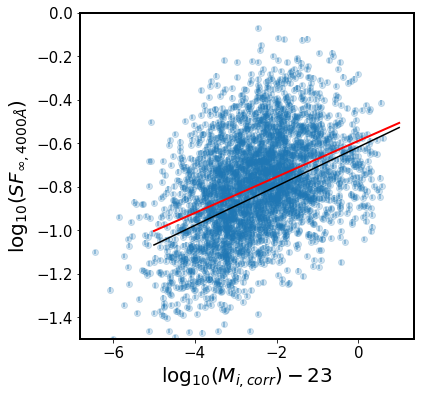

<Figure size 432x288 with 0 Axes>

In [12]:
meanA, meanC = np.mean(A), np.mean(C)

%matplotlib inline 
fig,ax = plt.subplots(1,1,figsize=(6,6))
# first let's visualize the data
ax.scatter(x1, y1, alpha=0.2)
ax.errorbar(x1, y1, xerr=sigma_lum , yerr=sigma_y , ls=' ', alpha=0.5)

# plot the best-fit line
m_fit, b_fit = get_m_b(beta_fit)
print('band-averaged slope C=',meanC ,' offset A=', meanA)
x_fit = np.linspace(-5,1, 10)
ax.plot(x_fit, meanC * x_fit + meanA, '-r',lw=2)
ax.set_ylim(-1.5,0)
ax.set_xlabel(r'$\log_{10}{(M_{i,corr})} - 23$')
ax.set_ylabel(r'$\log_{10}{(SF_{\infty, 4000 \AA})}  $')
# plot in black Chelsea's slope...
paperA, paperC = -0.618, 0.090
ys = paperA + x_fit * paperC
ax.plot(x_fit, ys, color='k')

plt.show()

plt.savefig('AstroML_fit_AC_MI_Z2.png', bbox_inches='tight')

In [182]:
# try if this will work ...
# Fit x1 ,x2 and y1 :  
# stack the latent variables x1, x2,  y1  ....
X = np.vstack((x1, x2, y1)).T
dX = np.zeros((len(x1), 3, 3))
dX[:, 0, 0] = sigma_lum ** 2.0
dX[:, 1, 1] = sigma_mbh ** 2.0
dX[:, 2, 2] = sigma_y ** 2.0
dX[:, 0, 1] = dX[:, 1, 0] = dX[:,0,2] = \
dX[:,2,0] = dX[:,1,2] = dX[:,2,1] = 0 # no cross-covariance ... 

min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func, x0=[-1, 1, 1])
print(beta_fit)


Optimization terminated successfully.
         Current function value: 2192.428711
         Iterations: 219
         Function evaluations: 397
[-0.00500944 -0.01678544  0.01514305]


In [183]:
def get_m1_m2_b(beta):
    ''' from perpendicular line to a plane 
    get the plane coefficients 
    m1*x1 + m2*x2 + y = b 
    
    normal vector is  (m1,m2,1)  
    
    incorporate b and length^2 : 
    
    beta = b / (1+m1^2 + m2^2) * (m1,m2,1)
    
    '''
    b = np.dot(beta, beta) / beta[2]
    m1 = beta[0] / beta[2]
    m2 = beta[1] / beta[2]
    
    return m1,m2,b 
print(get_m1_m2_b(beta_fit))

(-0.33080756922092025, -1.1084586763266668, 0.035406180874986377)


In [188]:
# Try using sklearn for simple multiple regression with no X errors...
# with sklearn
from sklearn import linear_model
regr = linear_model.LinearRegression()


sklearn.linear_model.LinearRegression()

In [235]:
# fitting  A,C,D ( setting E==0 )
# second line 
X = np.vstack([x1,x2]).T
print(np.shape(X))
print(np.shape(y1))
dy =  np.ones_like(y1) * sigma_y
print(np.shape(dy))
regr.fit(X, y1, dy )
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

print('A=', regr.intercept_)
print('C=', regr.coef_[0])  # M_i coeff
print('D=', regr.coef_[1])  # M_BH coeff 

(4660, 2)
(4660,)
(4660,)
Intercept: 
 -0.546323405706
Coefficients: 
 [ 0.11288415  0.12230746]
A= -0.546323405706
C= 0.112884147609
D= 0.122307455082


In [236]:
# fitting A,C,D, setting E == 1 
# third line 
X = np.vstack([x1,x2]).T
y = fo - red # here  y = log(SFinf) - B*log(lambda/4000) - E(1+z)
print(np.shape(X))
print(np.shape(y))
dy =  np.ones_like(y) * sigma_y
print(np.shape(dy))
regr.fit(X, y, dy )
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

print('A=', regr.intercept_)
print('C=', regr.coef_[0])  # M_i coeff
print('D=', regr.coef_[1])  # M_BH coeff 

(4660, 2)
(4660,)
(4660,)
Intercept: 
 -0.754842389628
Coefficients: 
 [ 0.19032872  0.12728304]
A= -0.754842389628
C= 0.190328722689
D= 0.127283040573


In [237]:
# fitting  A,C (setting D, E == 0 )
# fourth line 
X = x1.reshape(-1,1)
print(np.shape(X))
print(np.shape(y1))
dy =  np.ones_like(y1) * sigma_y
print(np.shape(dy))
regr.fit(X, y1, dy )

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

print('A=', regr.intercept_)
print('C=', regr.coef_[0])  # M_i coeff
#aprint('D=', regr.coef_[1])  # M_BH coeff 

(4660, 1)
(4660,)
(4660,)
Intercept: 
 -0.631276000175
Coefficients: 
 [ 0.07974407]
A= -0.631276000175
C= 0.079744071175


slope (m)= 0.0797486202484  offset (b)= -0.63126607786


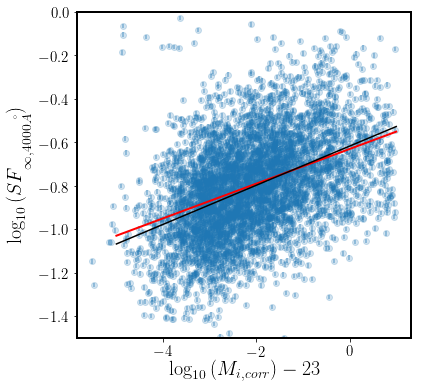

In [161]:
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm




In [162]:
ols?

In [175]:
beta

0.09

Optimization terminated successfully.
         Current function value: 55.711167
         Iterations: 88
         Function evaluations: 164


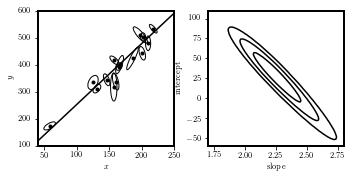

In [110]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

from astroML.linear_model import TLS_logL
from astroML.plotting.mcmc import convert_to_stdev
from astroML.datasets import fetch_hogg2010test

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


#------------------------------------------------------------
# Define some convenience functions

# translate between typical slope-intercept representation,
# and the normal vector representation
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b


def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])


# compute the ellipse pricipal axes and rotation from covariance
def get_principal(sigma_x, sigma_y, rho_xy):
    sigma_xy2 = rho_xy * sigma_x * sigma_y

    alpha = 0.5 * np.arctan2(2 * sigma_xy2,
                             (sigma_x ** 2 - sigma_y ** 2))
    tmp1 = 0.5 * (sigma_x ** 2 + sigma_y ** 2)
    tmp2 = np.sqrt(0.25 * (sigma_x ** 2 - sigma_y ** 2) ** 2 + sigma_xy2 ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha


# plot ellipses
def plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, factor=2, ax=None):
    if ax is None:
        ax = plt.gca()

    sigma1, sigma2, alpha = get_principal(sigma_x, sigma_y, rho_xy)

    for i in range(len(x)):
        ax.add_patch(Ellipse((x[i], y[i]),
                             factor * sigma1[i], factor * sigma2[i],
                             alpha[i] * 180. / np.pi,
                             fc='none', ec='k'))

#------------------------------------------------------------
# We'll use the data from table 1 of Hogg et al. 2010
data = fetch_hogg2010test()
data = data[5:]  # no outliers
x = data['x']
y = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
rho_xy = data['rho_xy']

#------------------------------------------------------------
# Find best-fit parameters
X = np.vstack((x, y)).T
dX = np.zeros((len(x), 2, 2))
dX[:, 0, 0] = sigma_x ** 2
dX[:, 1, 1] = sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y

min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func,
                         x0=[-1, 1])

#------------------------------------------------------------
# Plot the data and fits
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.15, top=0.9)

#------------------------------------------------------------
# first let's visualize the data
ax = fig.add_subplot(121)
ax.scatter(x, y, c='k', s=9)
plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, ax=ax)

#------------------------------------------------------------
# plot the best-fit line
m_fit, b_fit = get_m_b(beta_fit)
x_fit = np.linspace(0, 300, 10)
ax.plot(x_fit, m_fit * x_fit + b_fit, '-k')

ax.set_xlim(40, 250)
ax.set_ylim(100, 600)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

#------------------------------------------------------------
# plot the likelihood contour in m, b
ax = fig.add_subplot(122)
m = np.linspace(1.7, 2.8, 100)
b = np.linspace(-60, 110, 100)
logL = np.zeros((len(m), len(b)))

for i in range(len(m)):
    for j in range(len(b)):
        logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)

ax.contour(m, b, convert_to_stdev(logL.T),
           levels=(0.683, 0.955, 0.997),
           colors='k')
ax.set_xlabel('slope')
ax.set_ylabel('intercept')
ax.set_xlim(1.7, 2.8)
ax.set_ylim(-60, 110)

plt.show()